In [1]:
%load_ext autoreload
%autoreload 2
import sys
import glob
import json

import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from karateclub.graph_embedding.graph2vec import Graph2Vec
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

sys.path.append("../")
from src.graph2vec import Ensemble_G2V, ExtendedGraph2Vec
from src.utils import *

plt.rcParams["figure.figsize"] = (16, 40)

In [2]:
def load(fpath):
    data = json.load(open(fpath))
    label = data["label"]
    del data["label"]
    G = nx.node_link_graph(data)
    return G, label
def load_artificial(dirpath):
    graphs=[]
    labels=[]
    for fpath in tqdm(glob.glob(os.path.join(dirpath,"*.json"))):
        g,l=load(fpath)
        graphs.append(g)
        labels.append(l)
    return graphs,labels

In [8]:
graphs, labels = load_artificial("../datasets/partition_graphs/")

# generate_orderings("../datasets/partition_graphs/",graphs)

order_dict=np.load("../datasets/partition_graphs/orderings.npy", allow_pickle=True)[()]


  0%|          | 0/500 [00:00<?, ?it/s]

## Parameters section

In [9]:
subset_card = len(graphs)  # number of graphs

cross_val_k = 60
    # number of folds to perform in cross-validation (could be int or LeaveOneOut())

In [10]:
MEASURES = ["closeness_centrality", "pagerank"]#, "current_flow_closeness_centrality"]

tested_range = np.linspace(0, 1, 11)

WEIGHTING_FUNCTIONS = (
    {f"w_mean_{a:.2f}": ("w_mean",[a]) for a in tested_range}
    | {f"concat": ("concatenate",[])}
    | {f"p_proj_{a}": ("partial_projection",[0,a]) for a in (True,False)}
    | {f"w_proj_{a:.2f}": ("w_projection",[a]) for a in tested_range}
)

### Execution section

In [11]:
graphs_subset = graphs[:subset_card]

base_model=Graph2Vec()
without = ExtendedGraph2Vec()
with_dm = ExtendedGraph2Vec(use_pv_dm=True)
ens_model = Ensemble_G2V(without, with_dm)


### F1 score

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

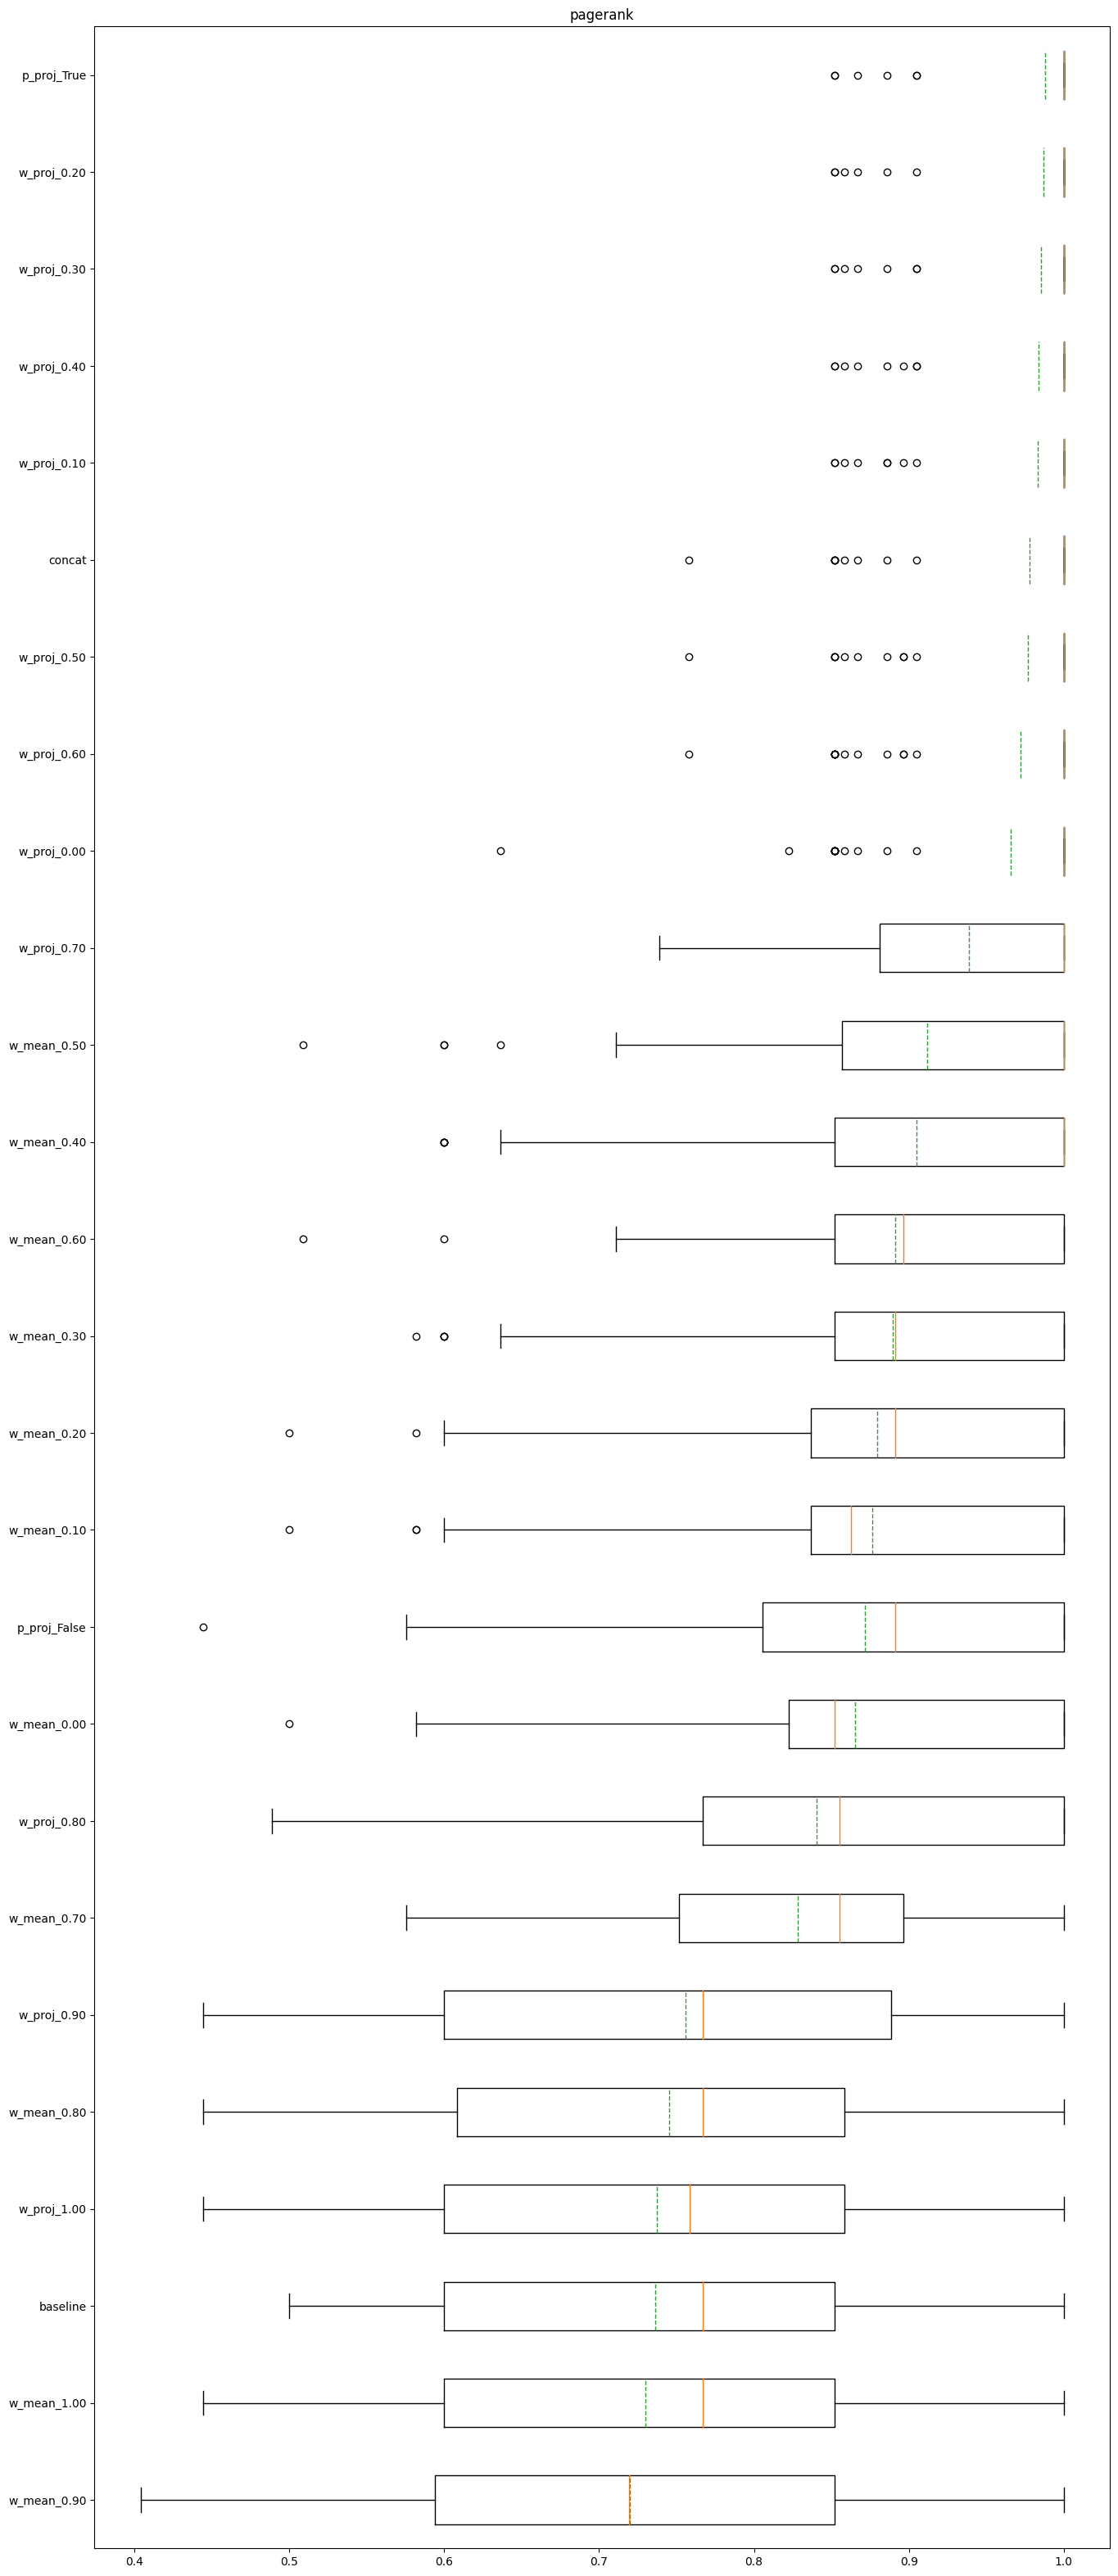

  0%|          | 0/25 [00:00<?, ?it/s]

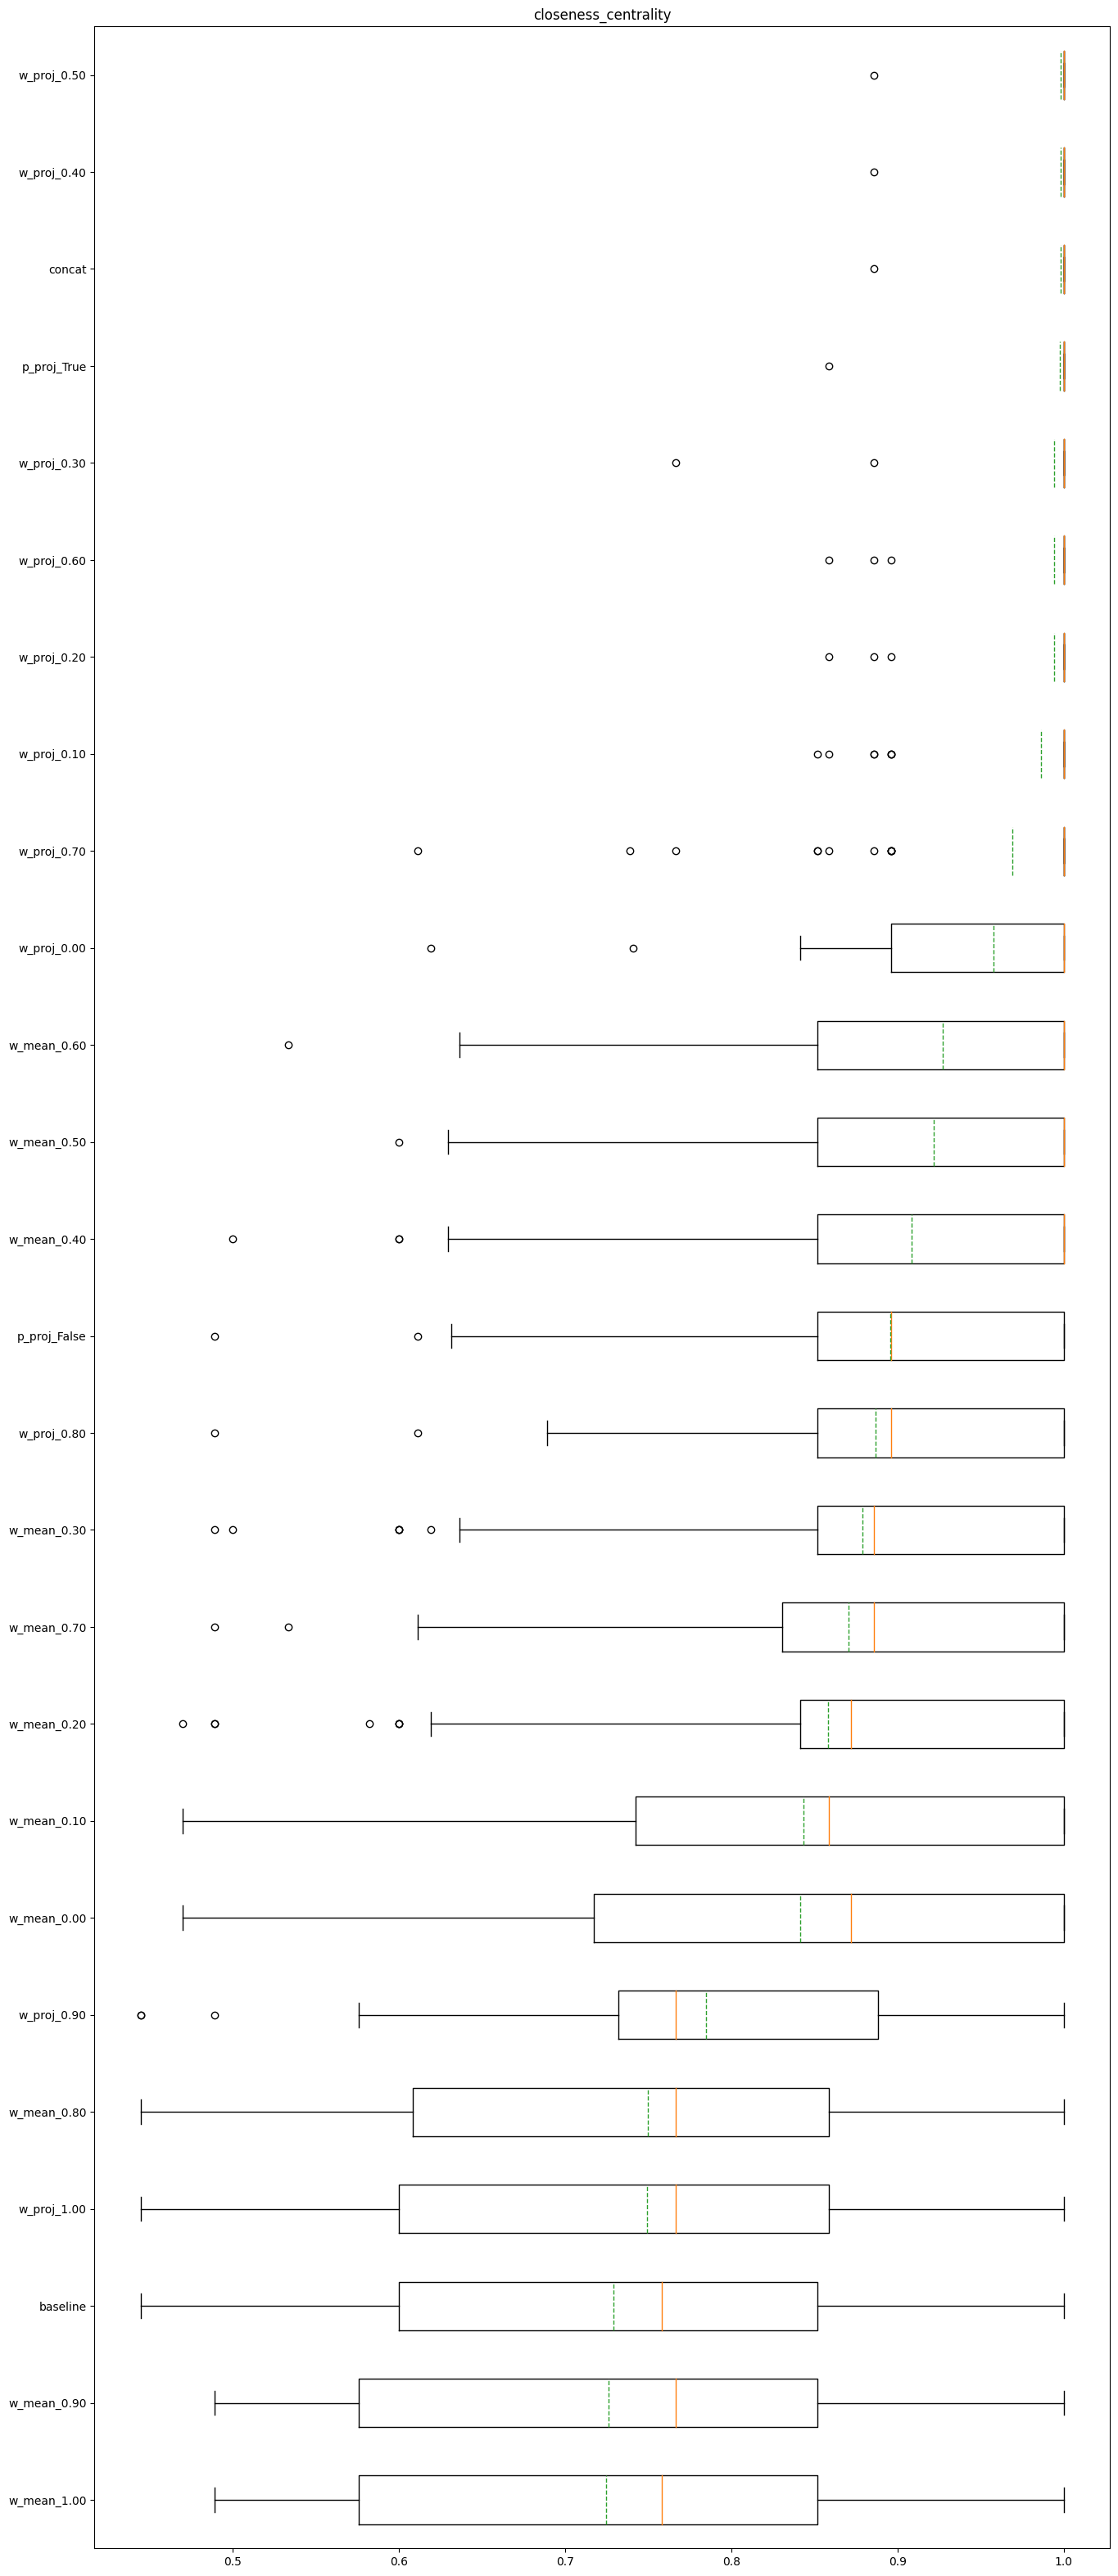

In [13]:
for measure, order in tqdm(order_dict.items()):
    base_model.fit(graphs_subset)
    res = {}
    ens_model.fit(graphs_subset, orderings=order)
    res["baseline"] = cross_validate(
    base_model.get_embedding(),
    labels,
    LogisticRegression(max_iter=1000),
    cv=cross_val_k,
    scoring="f1_macro",
    )
    for name, (func,args) in tqdm(WEIGHTING_FUNCTIONS.items(), leave=False):
        ens_model.set_weighting_function(func,*args)
        res[name] = cross_validate(
            ens_model.get_embedding(),
            labels,
            LogisticRegression(max_iter=1000),
            cv=cross_val_k,
            scoring="f1_macro"
        )
    n_items = len(res)
    plt.title(measure)
    plt.boxplot(
        sorted(res.values(),key=lambda x:x.mean()),
        positions=range(n_items),
        vert=False,
        showmeans=True,
        meanline=True,
    )
    plt.yticks(range(n_items), labels=sorted(res.keys(),key=lambda x:res[x].mean()))
    plt.show()

### Accuracy

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

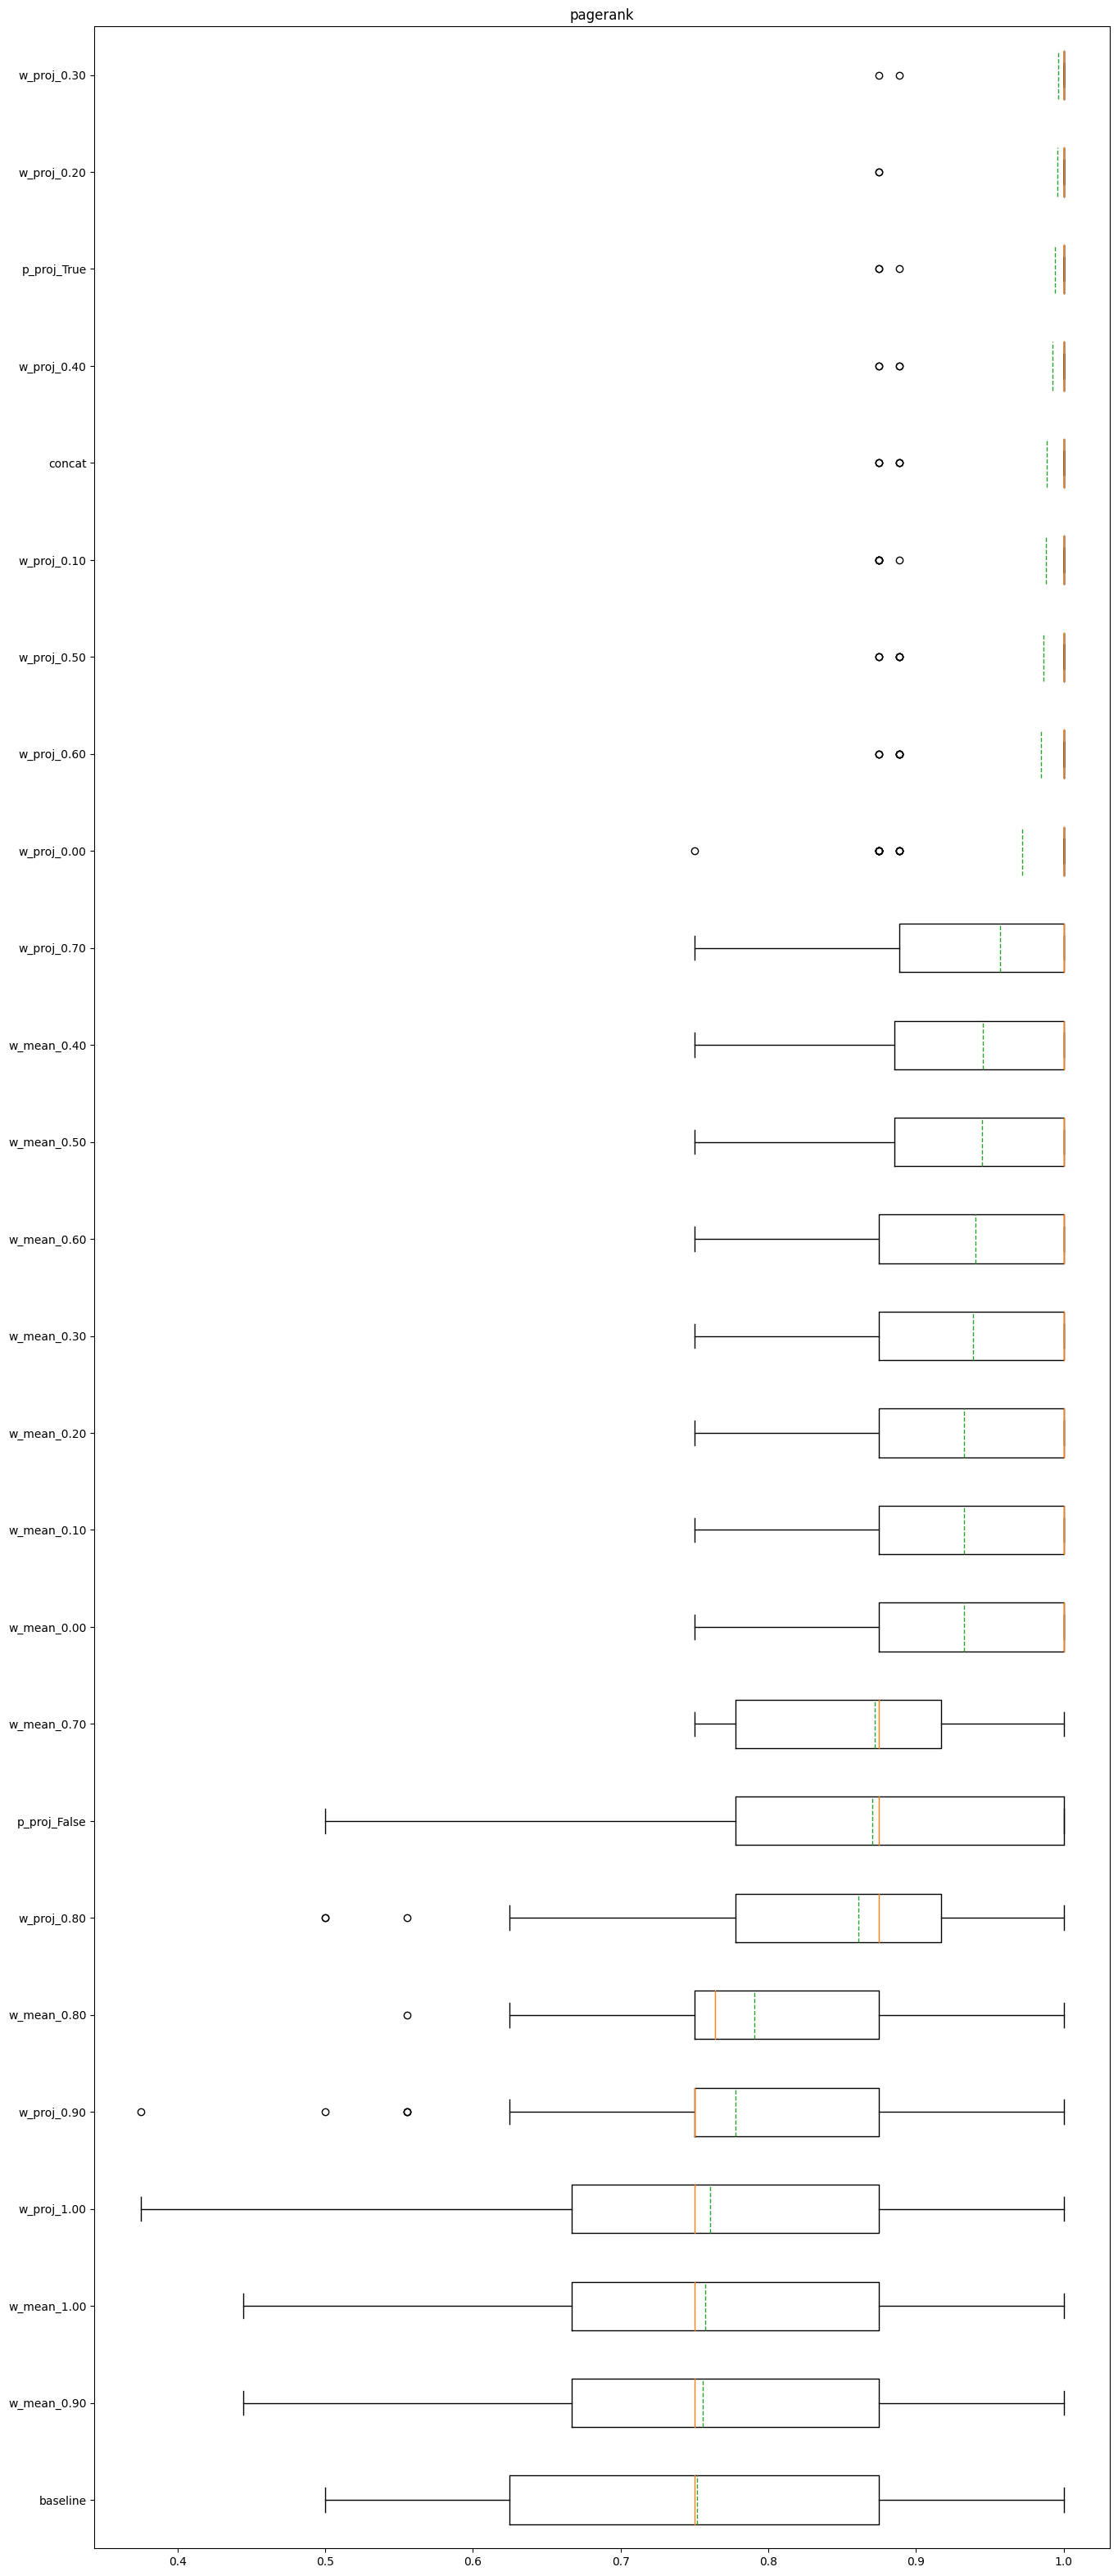

  0%|          | 0/25 [00:00<?, ?it/s]

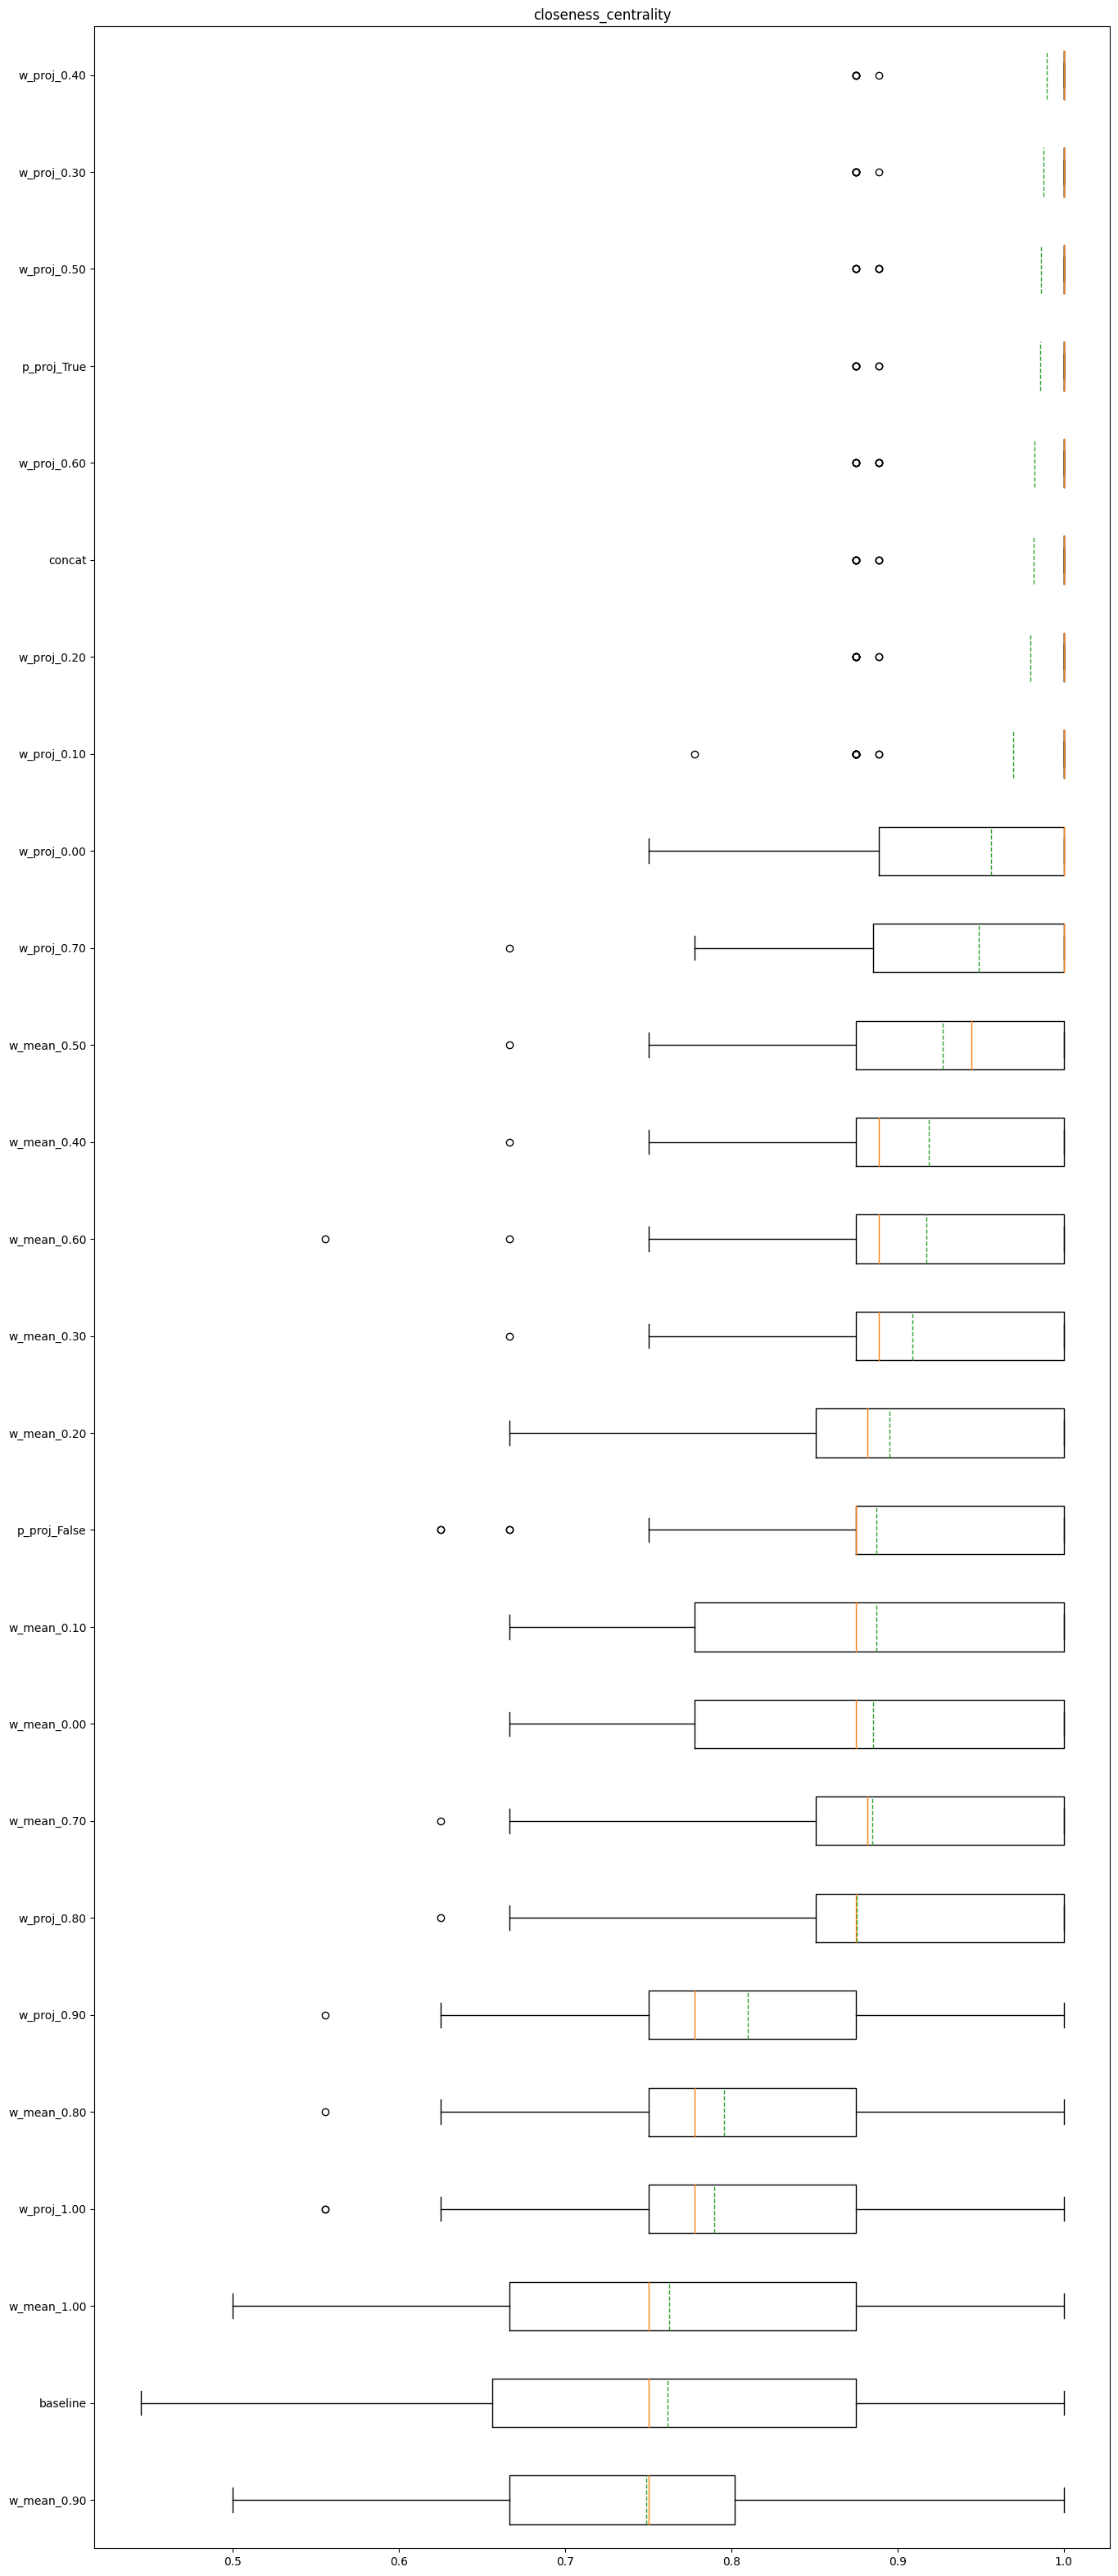

In [14]:
for measure, order in tqdm(order_dict.items()):
    base_model.fit(graphs_subset)
    res = {}
    ens_model.fit(graphs_subset, orderings=order)
    res["baseline"] = cross_validate(
    base_model.get_embedding(),
    labels,
    LogisticRegression(max_iter=1000),
    cv=cross_val_k,
    )
    for name, (func,args) in tqdm(WEIGHTING_FUNCTIONS.items(), leave=False):
        ens_model.set_weighting_function(func,*args)
        res[name] = cross_validate(
            ens_model.get_embedding(),
            labels,
            LogisticRegression(max_iter=1000),
            cv=cross_val_k,
        )
    n_items = len(res)
    plt.title(measure)
    plt.boxplot(
        sorted(res.values(),key=lambda x:x.mean()),
        positions=range(n_items),
        vert=False,
        showmeans=True,
        meanline=True,
    )
    plt.yticks(range(n_items), labels=sorted(res.keys(),key=lambda x:res[x].mean()))
    plt.show()